In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from os import listdir
from os.path import isfile, join

In [ ]:
#!git clone https://github.com/Marinku099/Sci-project-m5.git

In [ ]:
# not sure the real size
width = 450
hieght = 550

In [ ]:
df = pd.read_excel(r"data\cdi-data-scan1266.xlsx")
# df = df[["ID","Pt","DEP","Age","Sex"]] #1 = depressed

In [ ]:
df

In [ ]:
keys = []
# for number in range(1, 28):
#     key = 'EarnedPt' + str(number)
#     keys.append(key)

# keys.append("Pt")
keys.append("Age")
keys.append("Sex")
keys

In [ ]:
score = df.loc[0, keys]
score.to_numpy

In [ ]:
def labelfeatures(ID):
    i = df['Pt'][df['ID']==ID].index
    # score = df.loc[0, "Pt"]
    score = df.loc[i[0], keys]
    score.to_numpy()
    return score

In [ ]:
def labelY(ID):
    i = df['Pt'][df['ID']==ID].index
    # score = df.loc[0, "Pt"]
    y = df.loc[i[0], "Pt"]
    return y

In [ ]:
def img2data(path):
  img_data = []
  IDs = []
  features = []
  Y = []

  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for item in tqdm(os.listdir(folder_path)):
      filePath = os.path.join(folder_path, item)

      # print(item)
      ID = int(item.split('.')[0])
      IDs.append(ID)
      features.append(labelfeatures(ID))
      Y.append(labelY(ID))

      img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
      # plt.imshow(img)

      img = cv2.resize(img , (width, hieght))
      # img.flatten()
      # img.append(score)
      img = cv2.mean(img)

      img_data.append(img)

  return img_data, IDs, features, Y

In [ ]:
img, img_name, features, Y = img2data(r"data_label")
# print(img)

img = np.asarray(img)

# flattened_images = img.reshape(img.shape[0], -1)

In [ ]:
img

In [ ]:
# analyze with score feature
images_score = np.column_stack((img, features))

In [ ]:
# analyze with score, age, sex
images_score = np.column_stack((flattened_images, features))

In [ ]:
# analyze with images only
#images_score = flattened_images

In [36]:
images_score = np.delete(images_score, [1,2,3], 1)
images_score

array([[5.27429898989899, 12, 0],
       [4.192921212121212, 12, 0],
       [2.615911111111111, 13, 0],
       ...,
       [5.417688888888889, 14, 1],
       [3.781462626262626, 15, 1],
       [12.33290909090909, 11, 1]], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_score, Y, test_size=0.20, random_state=42)

In [ ]:
import plotly.express as px
err=[]
for k in range(2,10):
  print('k =',k)
  km=KMeans(k,n_init='auto')
  km.fit(X_train)
  err.append(km.inertia_)

px.line(x=[k for k in range(2,10)],y=err)

In [37]:
k = 2
kmeans = KMeans(k, random_state = 40)
kmeans.fit(images_score)

KMeans(n_clusters=2, random_state=40)

In [38]:
image_cluster = pd.DataFrame(img_name, columns=['image'])
len(kmeans.labels_)

470

In [ ]:
def labelscore(ID):
    
    i = df['Pt'][df['ID']==ID].index
    score = df.loc[i[0], 'Pt']
    return score

In [42]:

image_cluster["cluster"] = kmeans.labels_

# score_label = []

# for ID in image_cluster["image"]:
#     score_label.append(labelscore(ID))
# #image_cluster["cdi_score"] = features[:, 0]
# #image_cluster["age"] = features[:, 1]
# #image_cluster["sex"] = features[:, 2]
image_cluster["score"] = Y
image_cluster

,image,cluster,score
0,2,0,15
1,5,0,15
2,12,0,38
3,15,1,16
4,17,0,27
...,...,...,...
465,537,1,14
466,539,0,7
467,541,0,3
468,544,0,6


In [ ]:
def labelClass(ID):
    
    i = df['DEP'][df['ID']==ID].index
    score = df.loc[i[0], 'DEP']
    return score

def clusterClass(ID):
    i = image_cluster['clusterid'][image_cluster['image']==ID].index
    # print(i)
    score = image_cluster.loc[i[0], 'clusterid']
    return score

In [40]:
y_true = []

for id in image_cluster['image']:
    y_true.append(labelClass(id))

In [39]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
Ypred = kmeans.predict(images_score)

In [ ]:
Ypred

In [43]:
adjusted_mutual_info_score(y_true, image_cluster["cluster"])

0.005625450459360132

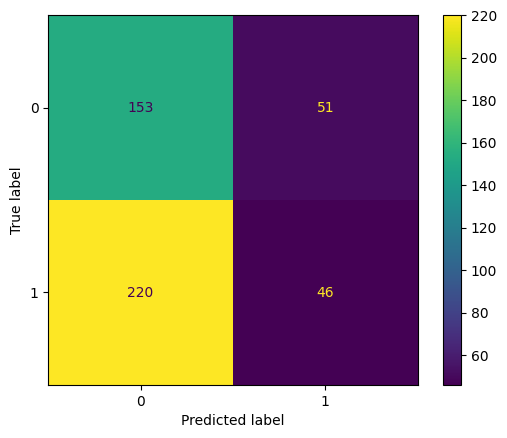

In [44]:
cm = confusion_matrix(y_true, image_cluster["cluster"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [45]:
f1_score(y_true, image_cluster["cluster"])

0.2534435261707989

In [ ]:
cm[:, 0]

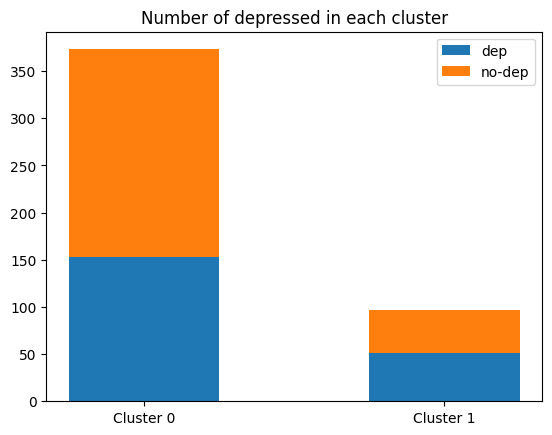

In [46]:
name_cluster = (
    "Cluster 0",
    "Cluster 1",
)
weight_counts = {
    "dep": cm[0],
    "no-dep": cm[1],
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(name_cluster, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of depressed in each cluster")
ax.legend(loc="upper right")

plt.show()

In [47]:
images_score[:, -3:]
# ช่อง 1 : คะแนน CDI
# ช่อง 2 : อายุ
# ช่อง 3 : เป็นโรคซึมเศร้าไหม

array([[5.27429898989899, 12, 0],
       [4.192921212121212, 12, 0],
       [2.615911111111111, 13, 0],
       ...,
       [5.417688888888889, 14, 1],
       [3.781462626262626, 15, 1],
       [12.33290909090909, 11, 1]], dtype=object)

In [48]:
centroids = kmeans.cluster_centers_
centroids

array([[ 4.7618977 , 13.769437  ,  0.50938338],
       [12.27401416, 13.62886598,  0.68041237]])

In [ ]:
images_score

In [ ]:
Y

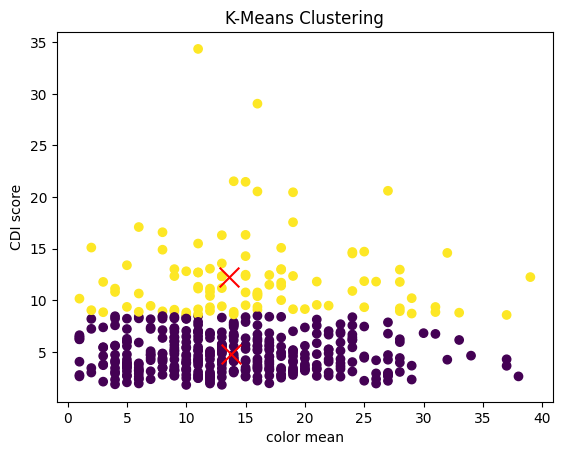

In [50]:
plt.scatter(image_cluster["score"], images_score[:, 0], c= image_cluster["cluster"], cmap='viridis')
plt.scatter( centroids[:, 1], centroids[:, 0], s=200, c='red', marker='x')
plt.title('K-Means Clustering')
plt.xlabel('color mean')
plt.ylabel('CDI score')
plt.show()

In [ ]:
images_score

In [51]:
import seaborn as sn

In [52]:
corr_df= pd.DataFrame(images_score)
corr_df['dep'] = image_cluster["cluster"]
corr_df['score'] = image_cluster["score"]

corr_df.rename(columns = {0:"color mean", 5:"sex", 4:"age"}, inplace = True)

corr_matrix = corr_df.corr(method='pearson')



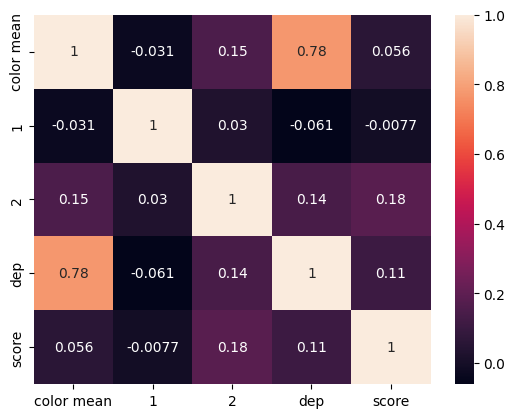

In [53]:

sn.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
corr_df